# 필요한 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

# [1. 삼성전자]

# 시계열 생성

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/samsung.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


**시계열 데이터는 결국 시간 컬럼을 index로 하는 Series로 표현**

위의 데이터프레임 파일은 아직 시계열 데이터 구조가 아님

우린 종가(Close) 데이터만 사용할 것이기 때문에

따라서 위의 DataFrame에서 Close 시계열을 생성

In [3]:
ts = df['Close']

print(type(ts))  # Series 데이터로 되었음
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [4]:
ts.shape

#데이터는 총 250개

(250,)

DataFrame인 df와 Series인 df['Close']는 index 구조가 동일하므로

Numpy, Pandas, Matplotlib 등 많은 라이브러리들이 호환해서 지원해주지만

그렇지 않은 경우도 간혹 발생하기 때문에 명확하게 Series 객체로 진행

## 정성분석, 정량분석 함수 생성

데이터의 안정성을 확인하기 위해 정성분석과 정량분석을 진행한다.

## 정성분석
- Rolling Statistics
- 현재 타임 스텝부터 window에 주어진 타임 스텝 이전 사이

 
1. 구간의 평균(rolling mean, 이동평균)


2. 표준편차(rolling std, 이동표준편차)


- **이동평균**

: 수의 집합에서 특정 크기의 부분 집합을 연속적으로 이동하며 산출한 평균

가격, 지수, 무게, 거래량, 거리 등 수치적으로 표현할 수 있는 모든 부분에 적용

한정되어 있는 수 집합의 모든 값을 대상으로 평균을 산출하는 일반평균과는 다르게

**일정한 크기의 부분집합을 평균 계산에 활용**

이 부분집합을 이동시키며 연속적인 평균값을 산출함으로써 **평균값의 흐름**을 알 수 있게 함

또한 이동평균계산을 진행할 경우 **일시적으로 발생한 돌출된 값은 평균에 의해 희석**되므로

지나친 과거 데이터로 인해 최근 형성된 데이터가 왜곡되는 문제를 방지

이는 데이터의 **추세 변화**를 확인하고 다양한 부분 집합 크기의 구간 간의 추세변화를 비교할 수 있음

In [5]:
def plot_rolling_statistics(timeseries, window=5):
    
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   #이동표준편차 시계열
    
    #원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

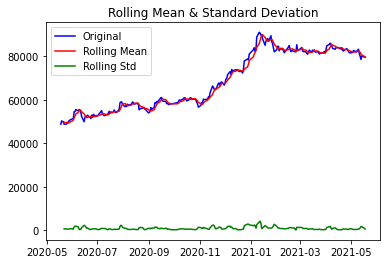

In [6]:
plot_rolling_statistics(ts, window = 5)

#주어진 데이터는 일별(월별, 연도별 x)로 데이터가 나뉘어있기 때문에 window를 일주일 단위인 5(주말 제외)로 설정했다.
#한 달로 끊기엔 30, 31 숫자가 애매하기 때문

시간의 추이에 따라 시계열의 평균과 분산이 지속적으로 커지는 패턴을 보이기 때문에

이 ts **데이터는 안정적이지 않다.** 

## 정량분석 ADF Test (Augmented Dickey-Fuller Test)

1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,


2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에


3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택

- **ADF 검정 : 정상성을 알아보기 위한 단위근 검정 방법**

단위근(unit root) : x=1, y=1인 해로, 시계열 자료에서 예측할 수 없는 결과를 가져올 수 있음

검정에는 자료에 단위근이 존재한다는 **귀무가설(H_0: α = 1)**과 

자료에 단위근이 존재하지 않아 시계열 자료가 정상성을 만족한다는 **대립가설(H_1 : α ≠ 1)**, 

이렇게 2가지 가설을 사용하고, 검정을 통해 귀무가설을 기각하면 정상성을 띤다고 볼 수 있음

참고 링크 : 

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

https://syj9700.tistory.com/30

In [7]:
from statsmodels.tsa.stattools import adfuller

#정량분석을 위한 ADF test 함수
def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'% key] = value
    print(dfoutput)

In [8]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistics                 -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


**p-value는 0.66 수준**으로 귀무가설을 기각할 수 없다.

즉, **불안정하다.**

# 데이터 전처리 - 데이터를 안정적으로 만들기
- 방법은 두 가지

1. 정성적인 분석을 통해 보다 안정적인 특성을 가지도록 **기존의 시계열 데이터를 가공/변형**


2. **시계열 분해(Time Series decomposition)** 기법을 적용

## 결측치 처리

1. 결측치가 있는 데이터를 모두 삭제(drop)


2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입

   ex. 2와 4 사이 데이터가 NaN이라면 이 값을 3(2와 4의 평균값)으로 채우는 방식

In [9]:
ts[ts.isna()]
#시계열에서 결측치가 있는 부분만 Series로 출력

#결측치 없음

Series([], Name: Close, dtype: float64)

결측치가 없으므로 따로 결측치 처리를 진행하지 않는다.

## 1. 기존의 시계열 데이터를 가공/변형

### 1-1. 로그 변환

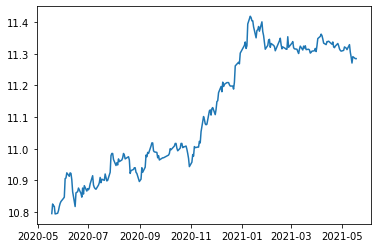

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

### 로그 변환의 효과가 어떠했는지 따져 보기 위해 정성분석과 Augmented Dickey-Fuller test 수행

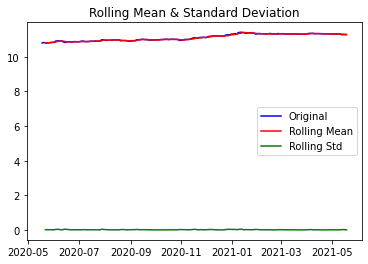

In [11]:
plot_rolling_statistics(ts_log, window = 5)

In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistics                 -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


그래프를 확인했을 때 **시간 추이에 따른 분산이 일정**해진 것을 확인했으나,

ADF test의 p-value값은 0.59 수준으로 여전히 높기 때문에 데이터는 **아직 불안정**하다는 것을 알 수 있다.

### 1-2. Moving average 제거 - 추세(Trend) 상쇄하기
- 추세(Trend) : 시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화
- 시간 추이에 따라 평균값이 변하면 안되니까 상쇄해줌

이 변화량을 제거해 주려면 거꾸로 Moving Average(rolling mean)을 구해서 ts_log에서 빼주면 됨

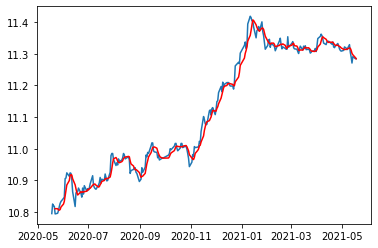

In [13]:
moving_avg = ts_log.rolling(window=5).mean()  #moving average 구하기
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

- 변화량 제거

In [14]:
ts_log_moving_avg = ts_log - moving_avg  
ts_log_moving_avg

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22   -0.016392
                ...   
2021-05-12   -0.021185
2021-05-13   -0.030659
2021-05-14   -0.006037
2021-05-17   -0.003452
2021-05-18    0.000528
Name: Close, Length: 250, dtype: float64

**문제 발생 !**

Moving Average 계산 시(windows size=5인 경우), 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 

ts_log_moving_avg에 결측치(NaN) 발생

- 해당 NaN 값들은 Dickey-Fuller Test 시에 에러를 발생시키므로 제거

In [15]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(10)

Date
2020-05-22   -0.016392
2020-05-25   -0.014548
2020-05-26   -0.002174
2020-05-27    0.011339
2020-05-28    0.019515
2020-05-29    0.017606
2020-06-01    0.018022
2020-06-02    0.013375
2020-06-03    0.054302
2020-06-04    0.040126
Name: Close, dtype: float64

### ts_log_moving_avg 정성, 정량 분석

- 정성분석

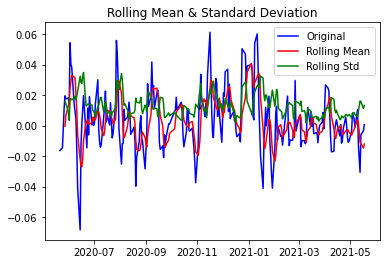

In [16]:
plot_rolling_statistics(ts_log_moving_avg)

- 정량분석

In [17]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistics               -7.801633e+00
p-value                        7.466367e-12
#Lags Used                     1.000000e+00
Number of observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


현저하게 낮은 p-value를 얻었기 때문에 귀무가설을 기각할 수 있다.

### 만약 window = 30 을 적용하면?

In [18]:
moving_avg_30 = ts_log.rolling(window=30).mean()
ts_log_moving_avg_30 = ts_log - moving_avg_30
ts_log_moving_avg_30.dropna(inplace=True)

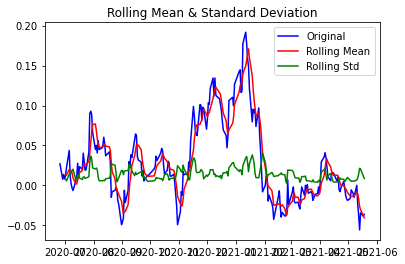

In [19]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [20]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test:
Test Statistics                 -2.241525
p-value                          0.191521
#Lags Used                       0.000000
Number of observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


window를 30으로 설정할 경우 0.19 수준의 p-value를 얻어 귀무가설을 기각할 수 없다.

그래프의 모양만 봐도 바로 확인할 수 있을 정도로 불안정하다는 것을 알 수 있다.

이를 통해 

**moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요**하다는 것을 깨달았다.

### 1-3 차분(Differencing) - 계절성(Seasonality) 상쇄하기
- 계절성(Seasonality) : Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 계절적 패턴
- 차분(Differencing) : 한 스텝 앞으로 이동한 시계열을 원래 시계열에 빼주는 방법 
     
     
- 남은 것은 (현재 스텝 값 - 직전 스텝 값) 이 되어 정확히 **이번 스텝에서 발생한 변화량**을 의미

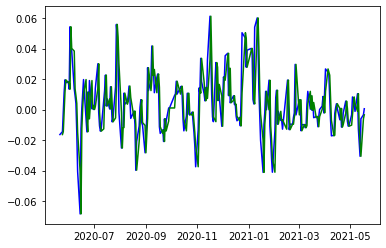

In [21]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- 원본 시계열에서 이동한 시계열을 뺀 값

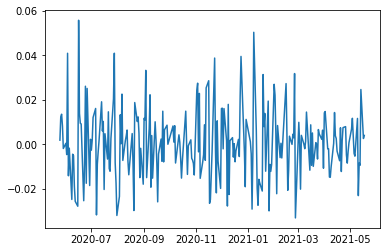

In [22]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

- 정성분석

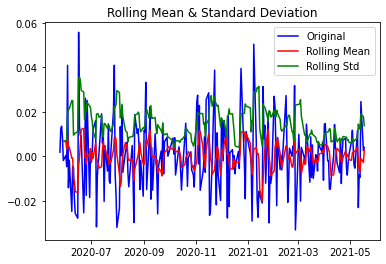

In [23]:
plot_rolling_statistics(ts_log_moving_avg_diff)

- 정량분석

In [24]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistics               -9.922422e+00
p-value                        2.966712e-17
#Lags Used                     5.000000e+00
Number of observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 

Seasonality 효과를 다소 상쇄한 결과, p-value가 2.966712e-17 수준으로 줄어듦.

1차 차분만으로 높은 안정성을 구할 수 있었다.

이렇게 하나하나 직접 추세와 계절성을 제거하고 차분을 적용하는 건 안정성을 찾기에 

효율적인 방법은 아니라고 생각했는데 생각보다 현저히 낮은 p-value를 얻게 되어서 의외였다.

window의 값을 잘 설정한 것이 좋은 결과에 큰 영향을 끼친 것 같다. 

## 시계열 분해 (Time series decomposition)
- **seasonal_decompose**
- 시계열 안에 존재하는 trend, seasonality를 직접 분리

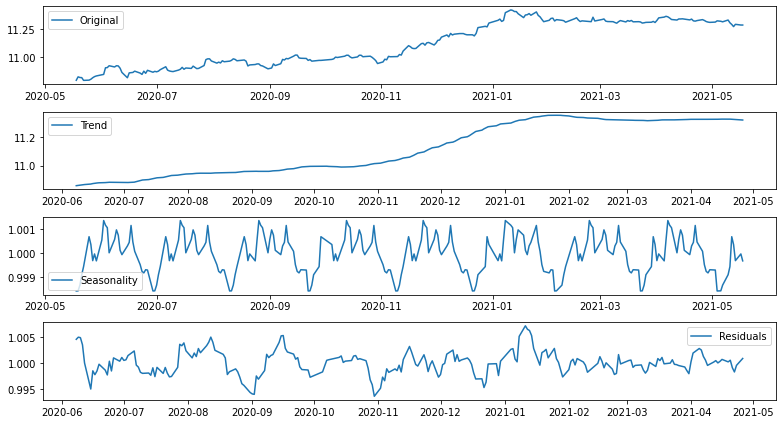

In [25]:
# 위에서 구했던 로그 변환 단계(ts_log)에서부터 출발

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  #추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal   #계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid   #원본(로그변환한) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)  #그래프 크기
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')   #알아서 가장 좋은 위치에 표시해라
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### original = trend + seasonality + residual

### Residual에 대한 안전성 여부

- 정성분석

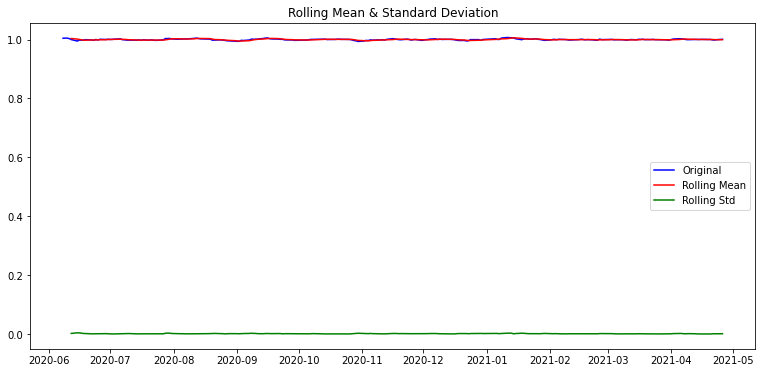

In [26]:
plt.rcParams['figure.figsize'] = (13, 6)
plot_rolling_statistics(residual)

- 정량분석

In [27]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistics               -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 **압도적으로 낮은 p-value** -> **예측 가능한 수준의 안정적인 시계열**

- 시계열 데이터가 Trend와 Seasonality, Residual로 분해되는 것을 확인


- **Trend와 Seasonality를 잘 분리해 낸 경우 Residual이 예측력 있는 안정적인 시계열 데이터**가 되는 것을 확인

# 학습, 테스트 데이터 분리
- 시계열 예측이므로 가장 나중 데이터를 테스트용으로 사용

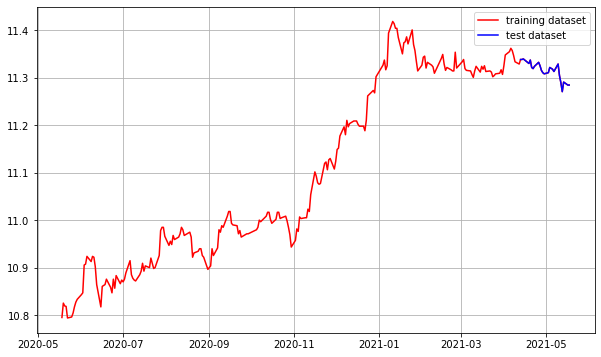

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [29]:
print(train_data.shape)
print(test_data.shape)

(225,)
(25,)


기껏 위에서 데이터 전처리를 해놓고 왜 학습, 테스트 데이터를 분리할 때 ts_log를 사용하는 지 의문이 들었다.

이유는 단순했다.

ARIMA 모델이 알아서 residual, seasonality, trend에 해당하는 부분을 모델링하기 때문이다.

# ARIMA 모델

### AR(Autoregressive) + I(Integrated) + MA(Moving Average)

## 1. ARIMA 모델 개념
### 1-1. AR(자기회귀, Autoregressive)

- **과거 값들에 대한 회귀로 미래 값을 예측하는 방법**
- Y_t가 **이전 p개의 데이터** Y_{t-1}, Y_{t-2}, ..., Y_{t-p} **의 가중합으로 수렴**한다고 보는 모델
- AR은 시계열의 **Residual에 해당하는 부분을 모델링**


- 가중치의 크기가 1보다 작은 Y_{t-1}, Y_{t-2}, ... , Y_{t-p}의 가중합으로 수렴하는 자기회귀 모델과 안정적 시계열은 통계학적으로 동치  
ex. 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점 = 주식 시계열을 AR로 모델링하는 관점

- 가중합 : 복수의 데이터를 단순히 합하는 것이 아니라, 각각의 수에 어떤 가중치 값을 곱한 후 이 곱셈 결과들을 다시 합한 것
- 동치 : 수학과 논리학에서 동치란 두 문장이 논리적으로 같다는 것을 의미.

### 1-2. I (차분 누적, Integration)
- Y_t 이 이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델
- 시계열의 **Seasonality에 해당하는 부분을 모델링**
- 예를 들어 d=1이라면 Y_t는 Y_{t-1}과 ΔY_{t-1} 의 합

### 1-3. MA(이동평균, Moving Average)
- Y_t 가 **이전 q개의 예측오차값** e_{t-1}, e_{t-2}, ..., e_{t-q} **의 가중합으로 수렴**한다고 보는 모델
- MA는 시계열의 **Trend에 해당하는 부분을 모델링**
- 예측오차값 e_{t-1}이 0보다 크면 모델 예측보다 관측값이 더 높다는 뜻이므로, 다음 Y_t 예측 시에는 예측치를 올려잡게 됨

ex. 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점 = MA로 모델링하는 관점

### 예를 들어,

**어제 주식값이 떨어졌다는 것을 알게 되었을 때**

- '오늘은 주식이 올라서 균형을 맞추겠지?'라는 **AR형태의 기대**


- '어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?'라는 **MA형태의 우려**


-> ARIMA는 두 모델 사이에서 적정 수준을 찾아감

## 2. ARIMA 모델의 모수(parameter) p, q, d 구하기
- **p** : 자기회귀 모형(AR)의 시차


- **d** : 차분 누적(I) 횟수


- **q** : 이동평균 모형(MA)의 시차

p 와 q 는 일반적으로 **p + q < 2, p * q = 0** 인 값을 사용

p 나 q 중 하나는 0

많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

### 적절한 p, q, d를 선택하는 방법

참고 링크 : https://hwao-story.tistory.com/13

### ACF (Autocorrelation Function)
= 자기 상관계수
- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
- 주어진 시계열의 현재 값이 과거(y_{t-1}, ... , y_{t-n})값과 어떻게 상관되는지 설명
- ACF plot에서 X축은 시차, Y축은 상관계수를 나타냄

### PACF (Partial Autocorrelation Function)
- 다른 관측치의 영향력을 배제하고 **두 시차의 관측치 간 관련성을 측정**하는 함수


- k 이외의 모든 시차를 갖는 관측치(y_{t-1}, ... , y_{t-k+1})의 영향력을 배제한 가운데 

    특정 두 관측치, y_t와 y_{t-k}가 얼마나 관련있는지 나타내는 척도 

참고 링크 : https://direction-f.tistory.com/65

### statsmodels에서 제공하는 ACF, PACF 플로팅 기능 사용

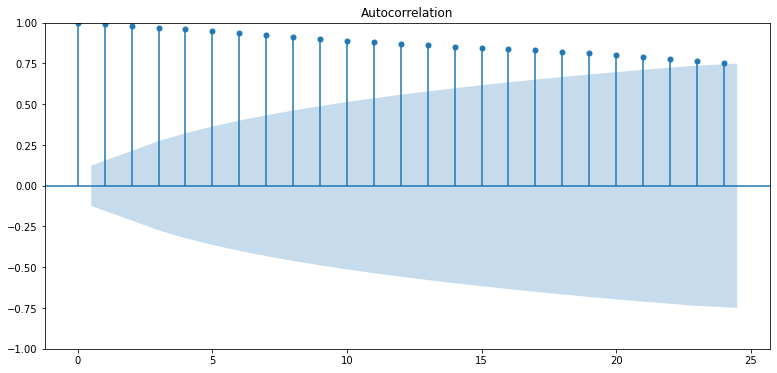

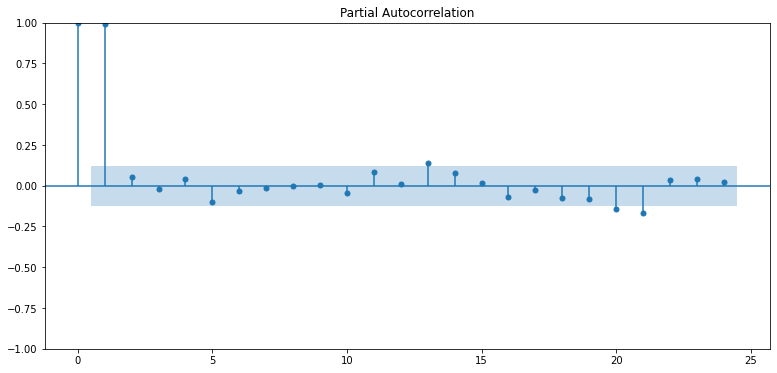

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프 
plot_pacf(ts_log)   #PACF : Partial Autocorrelation 그래프

plt.show()

### ACF-MA(q), PACF-AR(p) 요약 결론
ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음

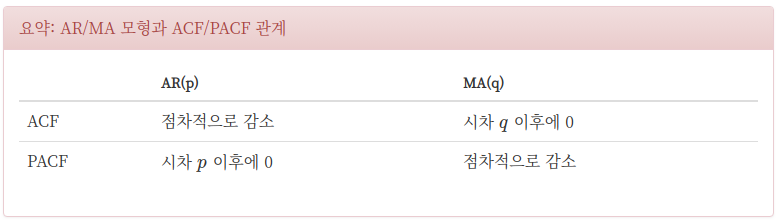

이 결론에 따르면 

p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에

**PACF 그래프를 볼 때 p=1이 매우 적합**하다. 

**PACF가 0이라는 의미**는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 

즉 **아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻**이다.


ACF는 점차적으로 감소하고 있어(AR(p=1) 모델에 유사한 형태), q에 대해서는 적합한 값이 없어 보인다.

따라서 **q=0**

- AR(1) 모델 : 직전 시점의 데이터로만 분석하는 모델

### d를 구하기 위해 d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인

- 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistics               -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


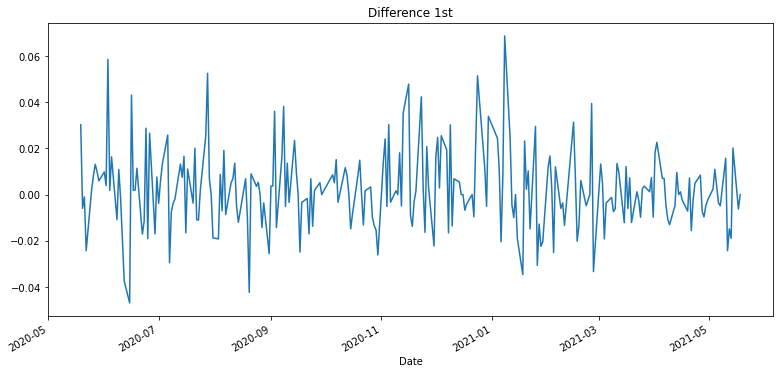

In [31]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

p-value가 2.183738e-28으로 도출되었으므로 1차 차분만으로 충분한 안정성을 띠는 것을 확인했다.

# 모델 훈련

In [86]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
#Build Model
model = ARIMA(train_data, order=(1, 1, 0))
                                # p, d, q
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Fri, 11 Feb 2022   AIC                          -1162.976
Time:                        06:57:32   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

## 모델 훈련 시각화

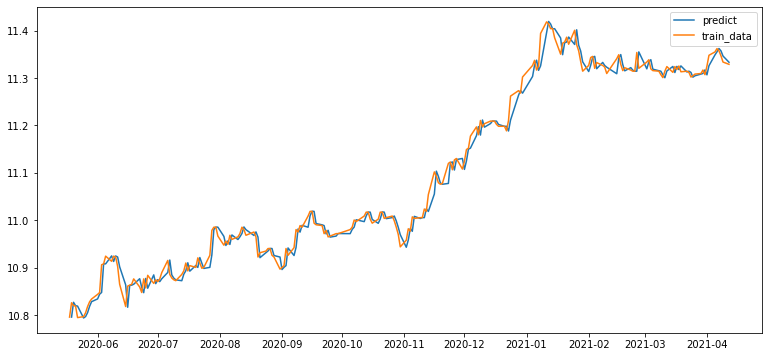

In [87]:
pred = fitted_m.predict()
pred = pred.drop(pred.index[0])
plt.plot(pred, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

### forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

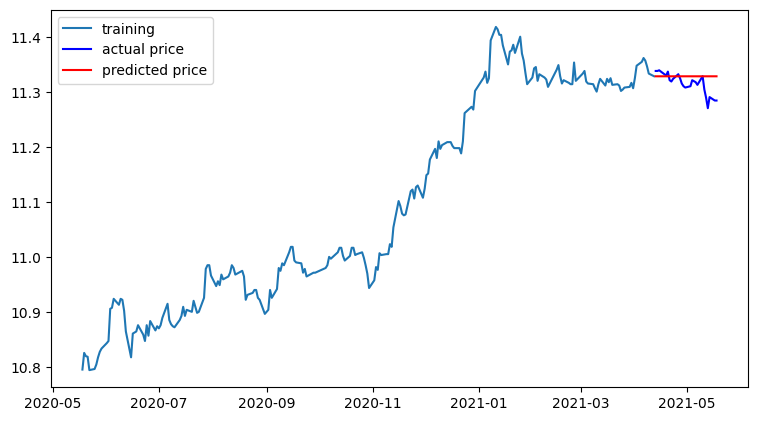

In [88]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측 결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

### 예측 결과가 일직선이 된 이유
예측값이 일직선으로 출력되어서 코드가 뭔가 잘못됐다고 생각해 원인을 구글링해본 결과

코드가 잘못된 것이 아니었고 예측에 사용하는 데이터에 원인이 있었다.

**"현재 사용한 모형은 1차 차분 시 "백색 잡음"인 모형이므로 상수항이 없는 "임의 보행 모형(Random Walk Model)" 을 따른다."**

라는 설명이 있었고 위 문장을 이해하기 위해 개념들을 정리해 보았다.

-------------

### 1) 백색 잡음

참고 링크 : https://ysyblog.tistory.com/213

: $y_t = \epsilon_t$  ($\epsilon_t \sim N(0,\sigma^2)$)

- **과거의 값으로 현재의 값을 예측할 수 없는 랜덤한 상태를 의미**

- **아무런 패턴이 남아있지 않는 무작위한 진동**

만약 추세나 계절성이 남아있으면 백색 잡음과는 멀어질 것. 이를 검증하는 것이 **잔차 진단**

- 백색 잡음은 다음과 같은 두 가지 속성을 만족해야 함

    1. 잔차들은 정규분포이고, 평균 0과 일정한 분산을 가져야 함.
    
    2. 잔차들이 시간의 흐름에 따라 상관성이 없어야 함
    
        * 자기 상관 함수(Autocorrelation Function(ACF))를 통해 자기상관=0인지 확인


### 2) 자기 상관 

: 시계열자료(time-series data)를 다루는 경우 항상 연속되는 오차항들이 서로 상관되어 있을 가능성이 존재. 

어떤 특정 시점에서 해당 시점의 오차항은 해당 시점의 충격 뿐 아니라 **과거로부터의 충격으로부터 이전된 영향들도 포함.**

이러한 이전된 영향으로 인해 **해당 시점의 충격은 과거의 충격들과 상관**될 것이며, 이러한 상황은 오차항들이 상관을 낳게 됨

이 경우 자기상관이 존재

자기 상관이 있다면 현재의 **오차항이 과거와 같은 부호**를 가지려는 경향이 있음

### 3) 임의 보행 모형 (확률 보행 모형)

: $y_t = y_{t-1} + \epsilon_t$

**현재의 값을 예측할 수 있는 가장 좋은 값은 어제의 값**

이 모형은 안정성을 띠지 않음. 

'오늘 시계열 값 ($y_t$)은 어제의 시계열 값 ($y_{t-1}$)에 예측할 수 없는 변화량 ($\epsilon_t$)을 더해 설명된다.'

확률론적 추세(Stochastic trend)가 존재하는 가장 단순한 모형

------------


위의 두 단어는 더 자세한 설명이 존재하지만 더 자세하게 들여다볼 경우 기간 내에 과제를 끝내지 못할 것 같아

간략하게 이해할 수 있는 정도로 알아보았다. 사실 지금도 겉핥기 식으로 이해했다.

각설하고, 

위의 개념 정리를 기반으로 현재 모형을 풀이해보면

**1차 차분을 했을 때, 과거의 값으로 현재의 값을 예측할 수 없는 안정성이 없는 상태이므로**

**결국 현재의 값을 예측하려면 어제의 값으로 하는 게 가장 좋다는 의미**라고 해석해볼 수 있다.

이 때 '과거'는 아마 바로 어제보다 더 먼 여러 날의 과거를 의미하는 듯하다.

예측을 할 때 $\epsilon_t$의 기댓값이 0이기 때문에 이 부분을 0으로 대체하게 된다.

$y_t = y_{t-1}$

따라서, **예측치들은 결국 가장 마지막 관측치**가 되는 것

즉, $\epsilon_t$ 부분은 0으로 대체되고, 

임의 보행 모형에서는 **예측치들이 가장 마지막 관측치로 동일하기 때문에 일직선을 얻게 된다.**

In [89]:
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MAPE: 1.74%


MAPE를 구해본 결과 1.74%로 좋은 결과가 도출되었다.

d를 0으로 할 경우 1.05%의 MAPE가 도출된다.

1차 차분을 하기 전 ts_log의 p-value는 0.59로 안정적이지 못한데,

왜 ARIMA 모델에 d값을 0으로 설정하는게 MAPE가 더 낮아지는 지 궁금하다.

## Auto ARIMA 적용
p, d, q를 정하는 법을 찾다가 **auto_arima**라는 함수가 있다는 것을 알게 되었다.

위의 예측에서 더 나아가 auto_arima 함수를 사용해 얻은 p, d, q를 사용하여 MAPE 결과를 비교해보고자 한다.

참고 링크 : https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/

In [36]:
model_aa = pm.auto_arima(y = train_data        # 데이터
                      , d = 1            # 차분 차수
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0
                      , max_q = 3  
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수
                      , stepwise = True
                      , trace=True
                      )

# p와 q의 값은 0~3 으로 설정
# 위에서 구한 차분은 1차분으로도 낮은 p-value가 도출되었기 때문에 d=1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1164.726, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.161 seconds


- **y**: array 형태의 시계열 자료


- **d (기본값 = none)**: 차분의 차수, 이를 지정하지 않으면 실행 기간이 매우 길어질 수 있음


- **start_p (기본값 = 2), max_p (기본값 = 5)**: AR(p)를 찾을 범위 (start_p에서 max_p까지 찾음)


- **start_q (기본값 = 2), max_q (기본값 = 5)**: MA(q)를 찾을 범위 (start_q에서 max_q까지 찾음)


- **m (기본값 = 1)**: 계절적 차분이 필요할 때 쓸 수 있는 모수
    
    $m=4$이면 분기별, $m=12$면 월별, $m=1$이면 계절적 특징을 띠지 않는 데이터를 의미. $m$=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정


- **seasonal (기본값 = True)**: 계절성 ARIMA 모형을 적합할지의 여부


- **stepwise (기본값 = True)**: 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부, False면 모든 모수 조합으로 모형을 적합


- **trace (기본값 = False)**: stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용

### 모델 학습

In [37]:
model_aa = pm.auto_arima(train_data, d = 1, seasonal = False)
fitted_aa = model_aa.fit(train_data)

auto_arima가 추정한 최적의 p, d, q 는 **(0, 1, 0)**으로 도출

결과를 보면 1차 차분을 했을 때 **백색 잡음 ($\epsilon_t \sim N(0,\sigma^2)$)**임을 의미하고, 

결국 아래 식처럼 **임의 보행 모형 (Random Walk Model)**을 따른다는 것

\\begin{aligned} y_t - y_{t-1} &= \epsilon_t\\ y_t &= y_{t-1} + \epsilon_t \end{aligned}

### 잔차 검정

In [38]:
print(model_aa.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 585.365
Date:                Fri, 11 Feb 2022   AIC                          -1166.730
Time:                        06:52:54   BIC                          -1159.906
Sample:                             0   HQIC                         -1163.975
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      1.922      0.055   -4.66e-05       0.005
sigma2         0.0003   2.48e-05     12.694      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

잔차에 대한 검정 통계량 **Prob (Q) 값을 보면 0.80**이므로 유의수준 0.05에서 귀무가설을 기각하지 못한다.

Ljung-Box (Q) 통계량의 귀무가설은 **“잔차가 백색잡음 시계열을 따른다”**이므로, 

위 결과를 통해 **시계열 모형이 잘 적합되었고, 남은 잔차는 더이상 자기상관을 가지지 않는 백색 잡음**임을 확인할 수 있다.

또한, **잔차가 정규분포**를 따른다면, 경험적으로

- 비대칭도 (Skew)는 0에 가까워야 하고

- 첨도 (Kurtosis)는 3에 가까워야 한다.


비대칭도는 0.52로 0에 가깝지만 첨도는 4.15로 3보다 더 높은 값을 가지고 있음을 알 수 있다.

이를 시각화하여 나타내면 아래와 같다.

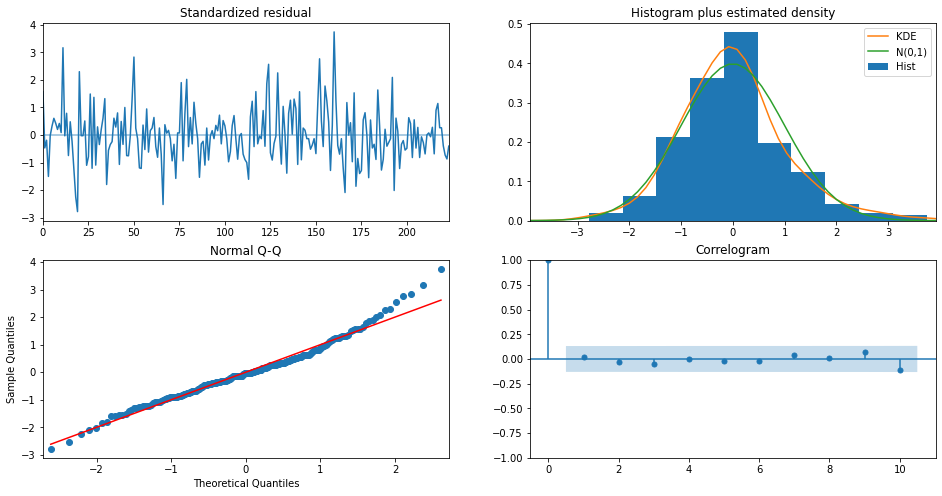

In [39]:
model_aa.plot_diagnostics(figsize=(16, 8))
plt.show()

#잔차가 백색 잡음을 따르는지 보여주는 플랏은 Standardized residual과 Correlogram 
#잔차가 정규성을 만족하는지 보여주는 플랏은 Histogram plus estimated density와 Normal Q-Q 그림

잔차의 시계열이 평균 0을 중심으로 무작위하게 움직이고, 어느 정도 허용 범위 안에 위치하여 자기상관이 없다.

정규분포와 비슷하게 대칭적이지만, 첨도가 더 뾰족하게 솟아올라있다.

### 예측

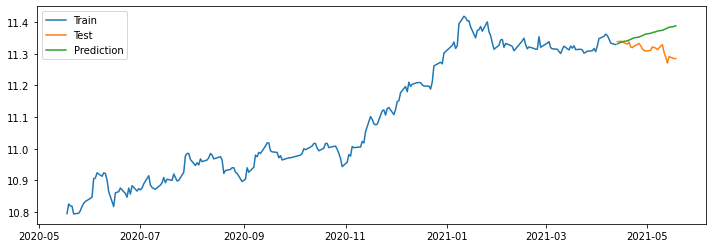

In [40]:
aa_predict = model_aa.predict(n_periods=len(test_data)) 
aa_predict_df = pd.DataFrame(aa_predict,index = test_data.index,columns=['Prediction'])

fc_aa = np.array(aa_predict)

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data, label='Train')        # 훈련 데이터
plt.plot(test_data, label='Test')          # 테스트 데이터
plt.plot(aa_predict_df, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [41]:
mape = np.mean(np.abs(np.exp(fc_aa) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MAPE: 4.69%


예측 결과 그래프를 보았을 때,

예측 결과를 나타내는 선과 실제 테스트 데이터의 선의 기울기가 반대로 나와있기 때문에

기울기가 0이었던 앞서 진행한 예측에 비해 예측력이 떨어지는 결과가 도출되었다. 

auto_arima를 사용하여 최적의 p,d,q 조합을 찾을 수 있을 것 같았는데

오히려 auto_arima를 사용하지 않으니 더 좋은 결과가 도출되었다.

# [2. Sk 이노베이션]

위에서 진행한 삼성전자 주식 가격 예측 과정을 기반으로 Sk 이노베이션 주가 예측을 진행해보고자 한다.

# 데이터 불러오기

In [42]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/skinnovation.KS.csv'
sk = pd.read_csv(dataset_filepath)
print(type(sk))
sk.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-10,291000.0,301000.0,285500.0,296500.0,296499.96875,1593876
1,2021-02-15,275000.0,289500.0,268000.0,284000.0,283999.96875,3822679
2,2021-02-16,286000.0,289500.0,278000.0,284500.0,284499.96875,1335559
3,2021-02-17,284000.0,297000.0,280000.0,297000.0,296999.96875,1890952
4,2021-02-18,298500.0,303000.0,293500.0,296000.0,295999.96875,1231945


- close(종가) 데이터만 Series로 만듦

In [43]:
ts_sk = sk['Close']

print(type(ts_sk))  # Series 데이터로 되었음
ts_sk.head()

<class 'pandas.core.series.Series'>


0    296500.0
1    284000.0
2    284500.0
3    297000.0
4    296000.0
Name: Close, dtype: float64

In [44]:
ts_sk.shape

#246개의 데이터

(246,)

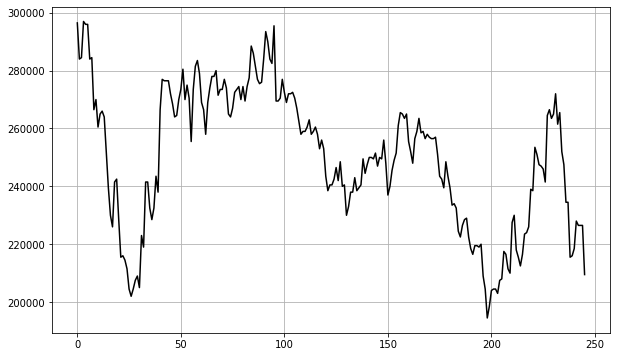

In [45]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_sk, c='black'); 

삼성전자 주가 그래프와 마찬가지로 안정성을 띠고 있지 않다.

In [46]:
ts_sk[ts_sk.isna()]
#시계열에서 결측치가 있는 부분만 Series로 출력

#결측치 없음

Series([], Name: Close, dtype: float64)

### 로그 변환

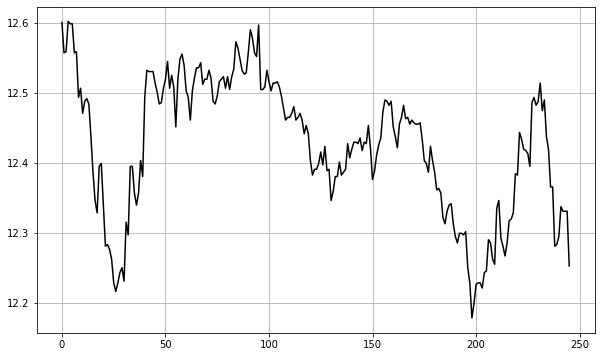

In [47]:
sk_log = np.log(ts_sk)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sk_log, c='black');

### 로그 변환 효과를 보기 위해 ADF test 진행

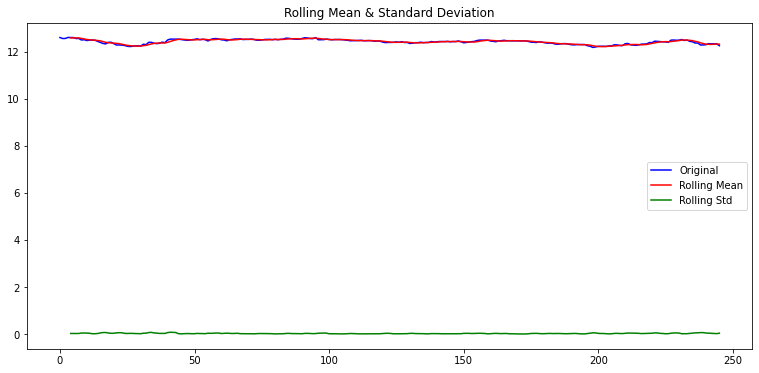

In [48]:
plot_rolling_statistics(sk_log, window = 5)

그래프를 확인했을 때 **시간 추이에 따른 분산이 일정**해진 것을 확인했다.

### 학습, 테스트 데이터 분리

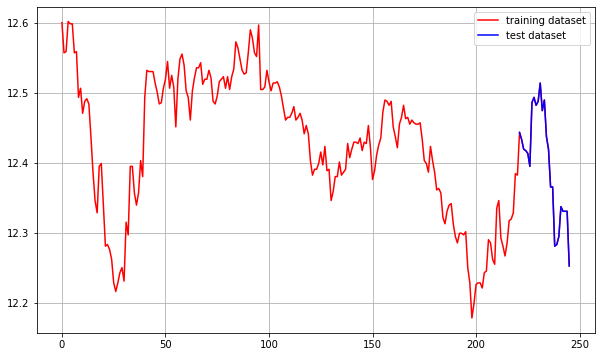

In [49]:
sk_train, sk_test = sk_log[:int(len(sk_log)*0.9)], sk_log[int(len(sk_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sk_log, c='r', label='training dataset') 
plt.plot(sk_test, c='b', label='test dataset')
plt.legend();

### ACF, PCAF 확인

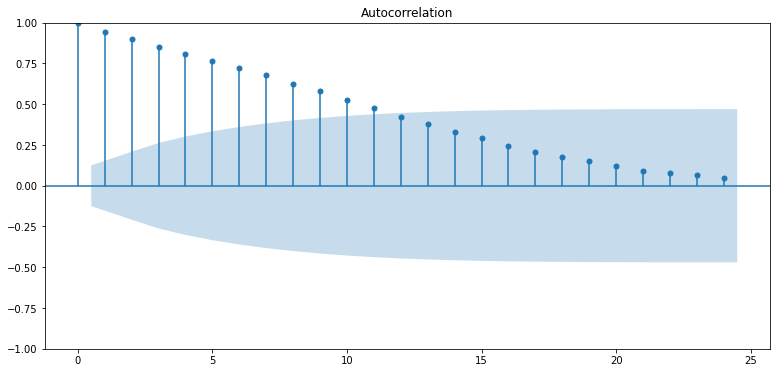

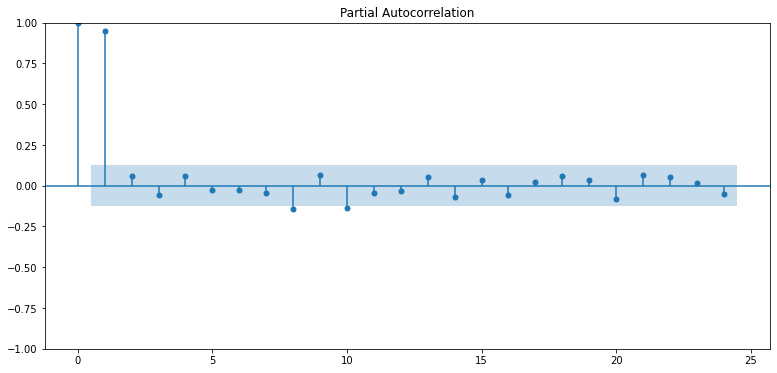

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sk_log)   #ACF : Autocorrelation 그래프 
plot_pacf(sk_log)   #PACF : Partial Autocorrelation 그래프

plt.show()

PCAF 그래프를 보면 절단값은 2다. 따라서 p=1, q=0으로 지정하여 모델을 학습하고자 한다.

### d 구하기

- 1차 차분

Results of Dickey-Fuller Test:
Test Statistics               -9.951432e+00
p-value                        2.508696e-17
#Lags Used                     2.000000e+00
Number of observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


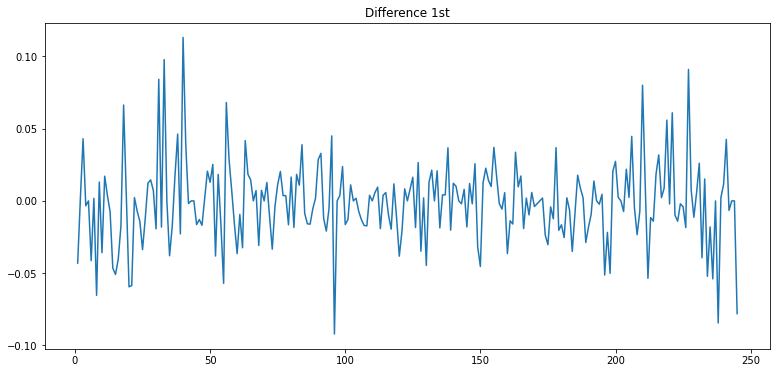

In [51]:
diff_1_sk = sk_log.diff(periods=1).iloc[1:]
diff_1_sk.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_sk)

1차 차분만으로도 p-value가 현저히 낮은 값이 도출되었기 때문에 d=1로 설정한다.

### 모델 훈련

In [52]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
#Build Model
model_sk = ARIMA(sk_train, order=(1, 1, 0))
                                # p, d, q
fitted_m_sk = model_sk.fit()

print(fitted_m_sk.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 481.995
Date:                Fri, 11 Feb 2022   AIC                           -959.989
Time:                        06:52:56   BIC                           -953.202
Sample:                             0   HQIC                          -957.249
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0144      0.071      0.203      0.839      -0.125       0.154
sigma2         0.0007   5.01e-05     14.593      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

### 모델 훈련 시각화

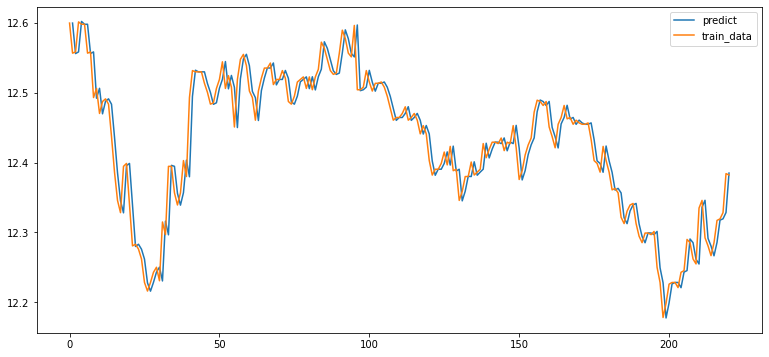

In [53]:
pred_sk = fitted_m_sk.predict()
pred_sk = pred_sk.drop(pred_sk.index[0])
plt.plot(pred_sk, label='predict')
plt.plot(sk_train, label='train_data')
plt.legend();

그래프를 보았을 땐 학습이 아주 잘 된 것으로 보인다.

### 예측 결과 시각화

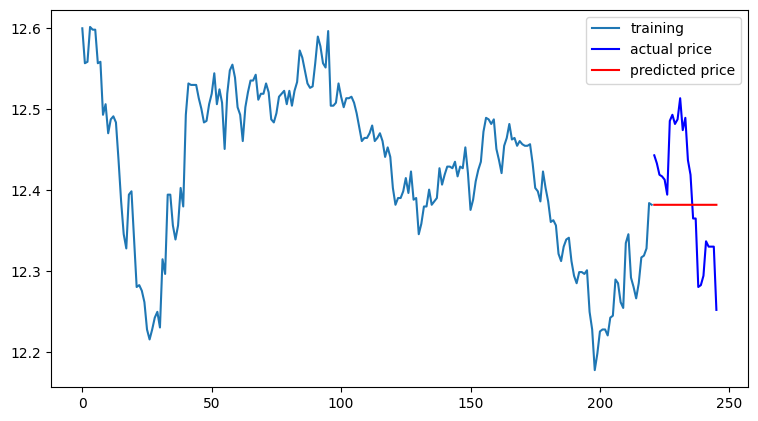

In [54]:
fc_sk = fitted_m_sk.forecast(len(sk_test), alpha=0.05)  #95% conf
fc_sk = np.array(fc_sk)

# Make as pandas series
fc_series_sk = pd.Series(fc_sk, index=sk_test.index)   #예측 결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(sk_train, label='training')
plt.plot(sk_test, c='b', label='actual price')
plt.plot(fc_series_sk, c='r', label='predicted price')
plt.legend()
plt.show()

이번 그래프 또한 예측 결과가 일직선으로 출력되었다.

위에서 알아본 것과 같이

특정한 안정성을 보이지 않기 때문에 이 모형에선 (t+1)시점의 값은 

바로 이전의 값(이 데이터에선 바로 전 날의 주가), t시점의 값에 가장 큰 영향을 받는다.

1차 차분 이후 백색 잡음 모형이 되기 때문에

상수항이 없는 임의 보행 모형을 따라서 예측치들이 가장 마지막 관측치로 동일하기 때문에 일직선이 된다.


### MAPE 확인

In [55]:
mape_sk = np.mean(np.abs(np.exp(fc_sk) - np.exp(sk_test))/np.abs(np.exp(sk_test)))
print('MAPE: {:.2f}%'.format(mape_sk*100))

MAPE: 6.81%


테스트 데이터의 그래프는 변동이 심한데 예측 그래프는 일직선이기 때문에 비교적 높은 MAPE값이 도출되었다.

# [3. KIA]

### 데이터 불러오기

In [56]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/kia.KS.csv'
kia = pd.read_csv(dataset_filepath)
print(type(kia))
kia.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-10,86300.0,87100.0,85100.0,86400.0,83332.546875,7223041
1,2021-02-15,86600.0,86900.0,85300.0,85700.0,82657.398438,4248831
2,2021-02-16,86200.0,86900.0,85300.0,85700.0,82657.398438,3576766
3,2021-02-17,85700.0,85700.0,83100.0,83200.0,80246.156250,4419413
4,2021-02-18,83400.0,84700.0,81000.0,81000.0,78124.257813,4762691


In [57]:
ts_kia = kia['Close']

print(type(ts_kia))  # Series 데이터로 되었음
ts_kia.head()

<class 'pandas.core.series.Series'>


0    86400.0
1    85700.0
2    85700.0
3    83200.0
4    81000.0
Name: Close, dtype: float64

In [58]:
ts_kia.shape

#246개의 데이터가 존재

(246,)

### 결측치 확인

In [59]:
ts_kia[ts_kia.isna()]
#있을 것 같던 결측치 없음

Series([], Name: Close, dtype: float64)

### 데이터 시각화

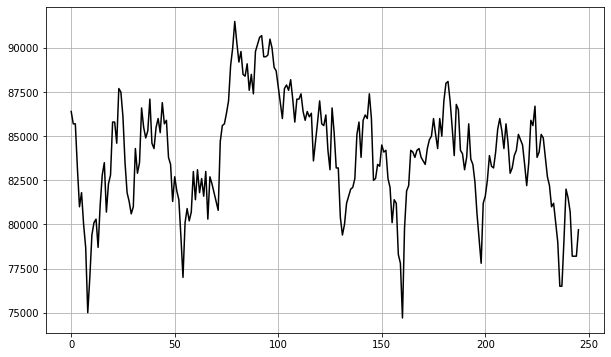

In [60]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_kia, c='black'); 

kia 데이터 또한 안정성이 존재하지 않는다.

사실 주식 데이터에서 안정성이 있을 것이라고 기대하는 것이 말이 안되는 것 같다.

분산을 줄여주기 위해 kia 데이터에도 로그 처리를 진행한다. 

### 로그 변환

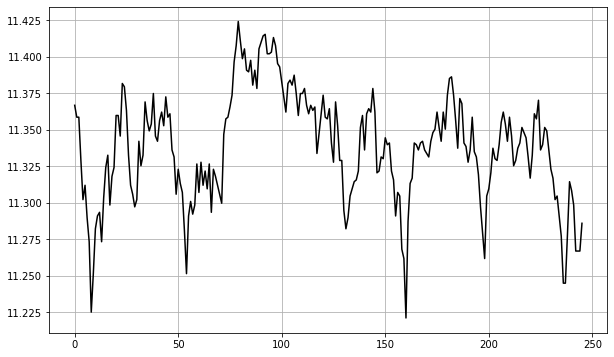

In [61]:
kia_log = np.log(ts_kia)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kia_log, c='black');

### 로그 변환 효과를 보기 위해 ADF test 진행

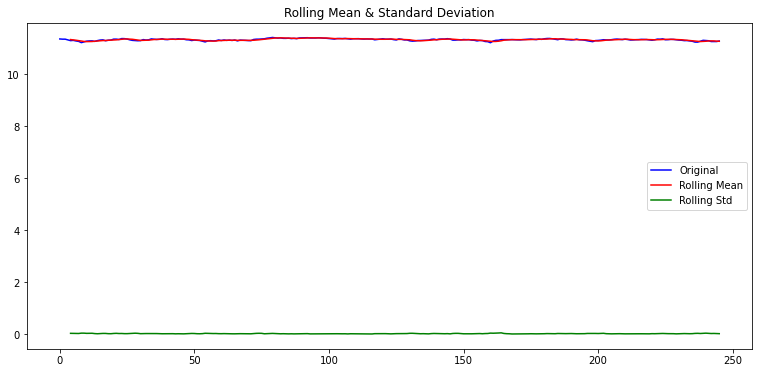

In [62]:
plot_rolling_statistics(kia_log, window = 5)

이번에도 그래프를 확인했을 때 **시간 추이에 따른 분산이 일정**해진 것을 확인했다.

### 학습, 테스트 데이터 분리

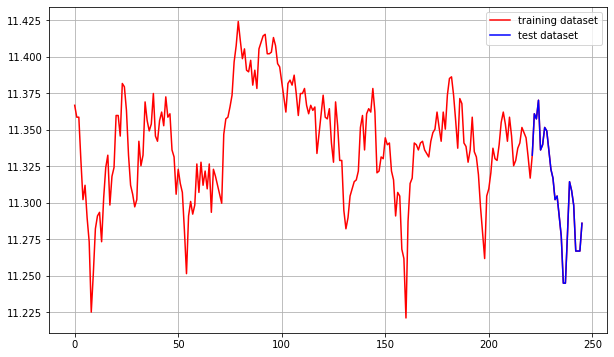

In [63]:
kia_train, kia_test = kia_log[:int(len(kia_log)*0.9)], kia_log[int(len(kia_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kia_log, c='r', label='training dataset') 
plt.plot(kia_test, c='b', label='test dataset')
plt.legend();

### ACF, PACF 확인

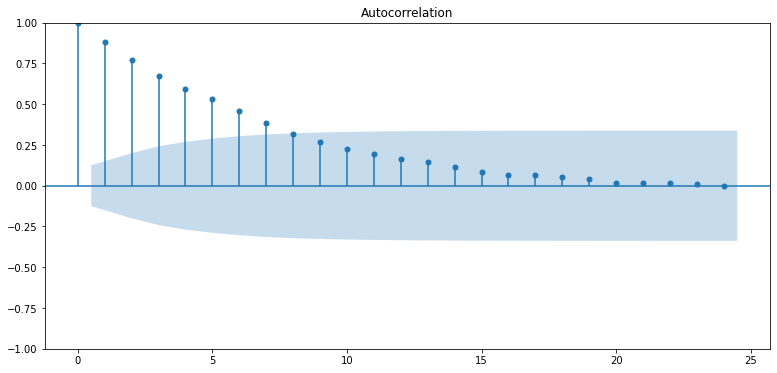

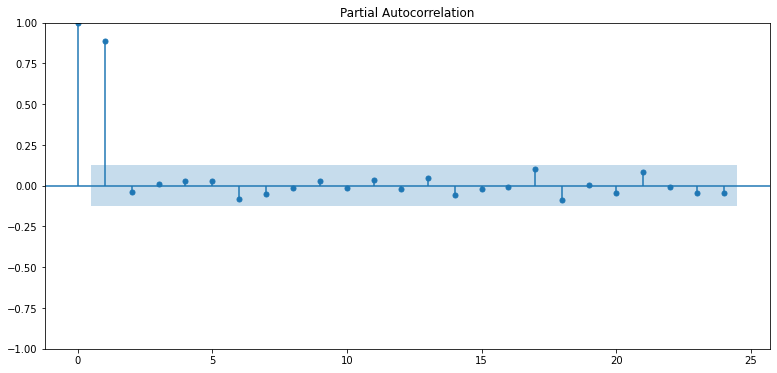

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kia_log)   #ACF : Autocorrelation 그래프 
plot_pacf(kia_log)   #PACF : Partial Autocorrelation 그래프

plt.show()

위의 두 종목과는 색다른 ACF 그래프가 그려졌다.

우선 PACF 그래프는 동일하기 때문에 모델을 훈련할 때 p=1, q=0으로 진행해보고,

ACF 그래프에서 9부터 파란색 띠에 진입하고, 20부터는 거의 0에 수렴하기 때문에 q값을 바꿔보며 모델을 학습해보고자 한다.

### d 구하기

Results of Dickey-Fuller Test:
Test Statistics               -1.604530e+01
p-value                        5.853817e-29
#Lags Used                     0.000000e+00
Number of observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


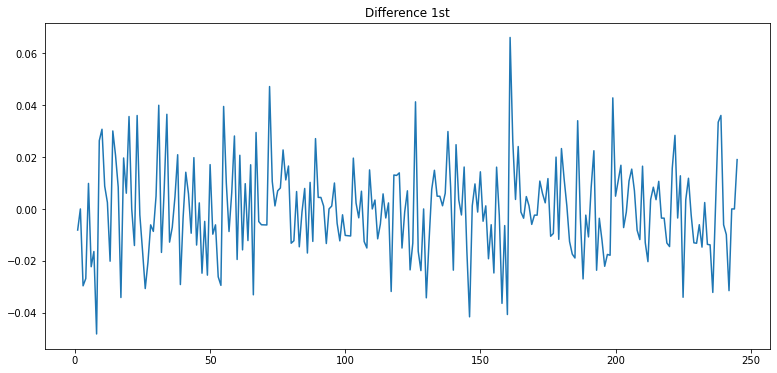

In [65]:
kia_diff_1 = kia_log.diff(periods=1).iloc[1:]
kia_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(kia_diff_1)

1차 차분만 진행해도 충분히 낮은 p-value가 도출되었다.

d는 1로 설정한다.

### 모델 훈련 (1)

In [66]:
from statsmodels.tsa.arima.model import ARIMA
#Build Model
model_kia = ARIMA(kia_train, order=(1, 1, 0))
                                 # p, d, q
fitted_m_kia_1 = model_kia.fit()

print(fitted_m_kia_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 574.255
Date:                Fri, 11 Feb 2022   AIC                          -1144.511
Time:                        06:52:58   BIC                          -1137.724
Sample:                             0   HQIC                         -1141.770
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0626      0.061     -1.024      0.306      -0.182       0.057
sigma2         0.0003   2.81e-05     11.265      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

### 모델 훈련 시각화 (1)

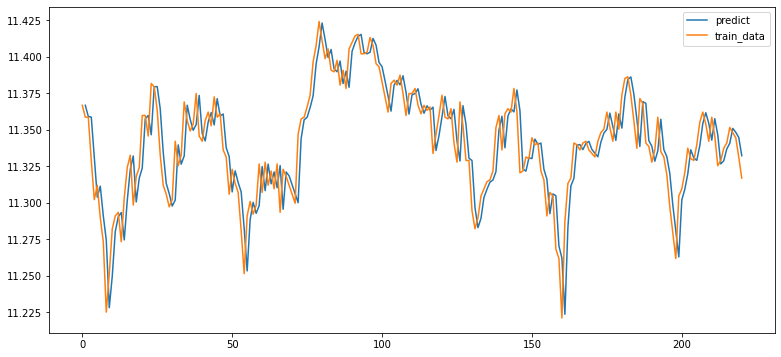

In [67]:
pred_kia_1 = fitted_m_kia_1.predict()
pred_kia_1 = pred_kia_1.drop(pred_kia_1.index[0])
plt.plot(pred_kia_1, label='predict')
plt.plot(kia_train, label='train_data')
plt.legend();

### 예측 결과 시각화 (1)

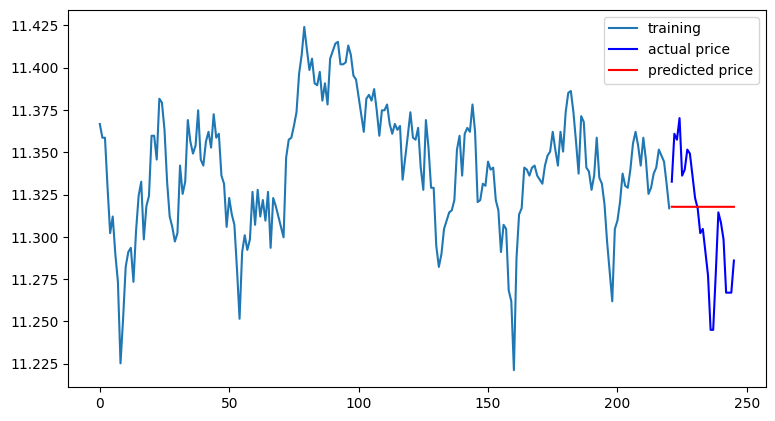

In [68]:
fc_kia_1 = fitted_m_kia_1.forecast(len(kia_test), alpha=0.05)  #95% conf
fc_kia_1 = np.array(fc_kia_1)

# Make as pandas series
fc_series_kia_1 = pd.Series(fc_kia_1, index=kia_test.index)   #예측 결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(kia_train, label='training')
plt.plot(kia_test, c='b', label='actual price')
plt.plot(fc_series_kia_1, c='r', label='predicted price')
plt.legend()
plt.show()

이번에 사용한 p, q, d는 위의 두 종목에 적용한 1, 0, 1로 일직선이 나올 수 밖에 없는 결과이다.

현재 시각화 결과를 보았을 때, 예측력은 매우 떨어지는 것 같다.

### MAPE 확인(1)

In [69]:
mape_kia_1 = np.mean(np.abs(np.exp(fc_kia_1) - np.exp(kia_test))/np.abs(np.exp(kia_test)))
print('MAPE: {:.2f}%'.format(mape_kia_1*100))

MAPE: 3.14%


MAPE가 얼마나 작아야 좋은 결과를 나타내는 지에 대해 의문이 생기는 결과이다.

3.14%면 수치상으로 100에 비해서 현저히 작은 값이기 때문에 예측력이 높은 결과일 것이라고 생각했는데

전혀 그렇지 않다.

### p, d, q 를 재설정한 후 모델링
위의 ACF 그래프에서 9에서부터 파란 띠 범위에 진입하고 20부터 0에 수렴하기 때문에 이 두 값을 반영하여 p, d, q를 설정해보고자 한다.

### 모델 훈련 (2)

In [70]:
model_kia_2 = ARIMA(kia_train, order=(0, 1, 9))
                                    # p, d, q
fitted_m_kia_2 = model_kia_2.fit()

print(fitted_m_kia_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(0, 1, 9)   Log Likelihood                 578.877
Date:                Fri, 11 Feb 2022   AIC                          -1137.753
Time:                        06:53:00   BIC                          -1103.817
Sample:                             0   HQIC                         -1124.049
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1058      0.068     -1.560      0.119      -0.239       0.027
ma.L2         -0.1030      0.076     -1.362      0.173      -0.251       0.045
ma.L3         -0.0595      0.068     -0.869      0.3

### 모델 훈련 시각화 (2)

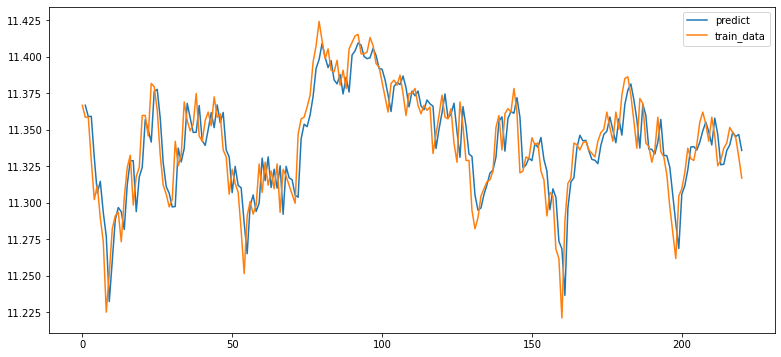

In [71]:
pred_kia_2 = fitted_m_kia_2.predict()
pred_kia_2 = pred_kia_2.drop(pred_kia_2.index[0])
plt.plot(pred_kia_2, label='predict')
plt.plot(kia_train, label='train_data')
plt.legend();

### 예측 결과 시각화 (2)

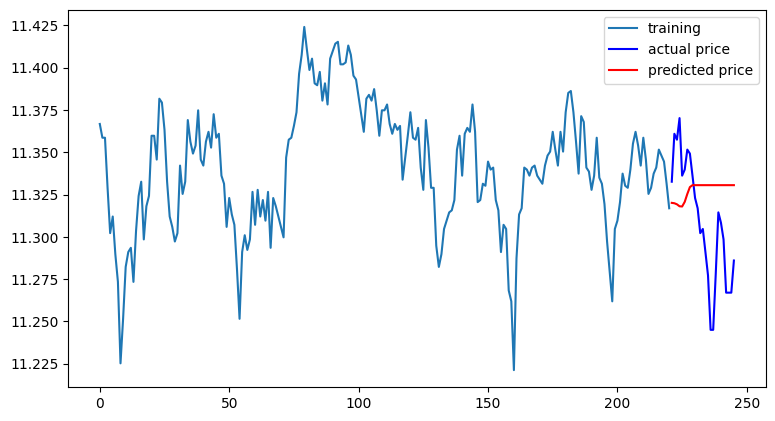

In [72]:
fc_kia_2 = fitted_m_kia_2.forecast(len(kia_test), alpha=0.05)  #95% conf
fc_kia_2 = np.array(fc_kia_2)

# Make as pandas series
fc_series_kia_2 = pd.Series(fc_kia_2, index=kia_test.index)   #예측 결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(kia_train, label='training')
plt.plot(kia_test, c='b', label='actual price')
plt.plot(fc_series_kia_2, c='r', label='predicted price')
plt.legend()
plt.show()

### MAPE 확인 (2)

In [73]:
mape_kia_2 = np.mean(np.abs(np.exp(fc_kia_2) - np.exp(kia_test))/np.abs(np.exp(kia_test)))
print('MAPE: {:.2f}%'.format(mape_kia_2*100))

MAPE: 3.78%


3.44%에서 3.78%로 오히려 예측력이 더 떨어졌다.

### 모델 훈련 (3)

In [74]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
#Build Model
model_kia_3 = ARIMA(kia_train, order=(0, 1, 20))
                                    # p, d, q
fitted_m_kia_3 = model_kia_3.fit()

print(fitted_m_kia_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(0, 1, 20)   Log Likelihood                 584.594
Date:                Fri, 11 Feb 2022   AIC                          -1127.187
Time:                        06:53:06   BIC                          -1055.921
Sample:                             0   HQIC                         -1098.408
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1070      0.076     -1.412      0.158      -0.255       0.042
ma.L2         -0.1036      0.079     -1.314      0.189      -0.258       0.051
ma.L3         -0.0086      0.079     -0.109      0.9

### 모델 훈련 시각화 (3)

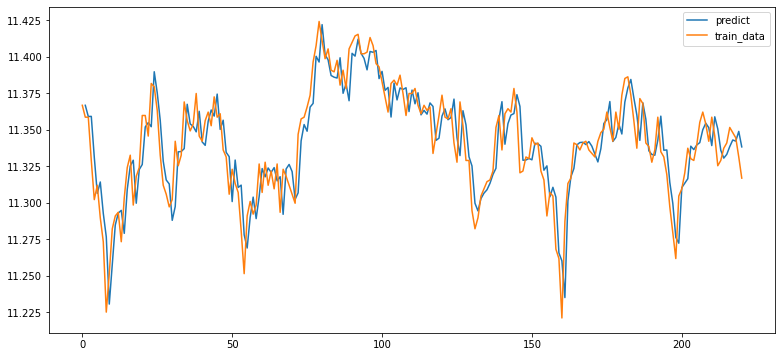

In [75]:
pred_kia_3 = fitted_m_kia_3.predict()
pred_kia_3 = pred_kia_3.drop(pred_kia_3.index[0])
plt.plot(pred_kia_3, label='predict')
plt.plot(kia_train, label='train_data')
plt.legend();

### 예측 결과 시각화 (3)

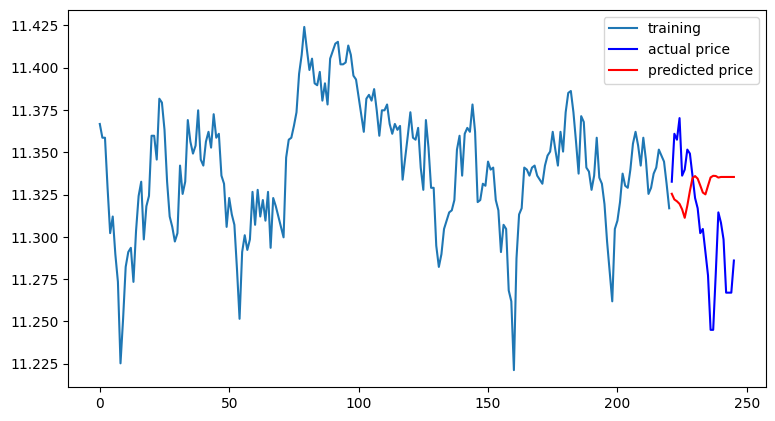

In [76]:
fc_kia_3 = fitted_m_kia_3.forecast(len(kia_test), alpha=0.05)  #95% conf
fc_kia_3 = np.array(fc_kia_3)

# Make as pandas series
fc_series_kia_3 = pd.Series(fc_kia_3, index=kia_test.index)   #예측 결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(kia_train, label='training')
plt.plot(kia_test, c='b', label='actual price')
plt.plot(fc_series_kia_3, c='r', label='predicted price')
plt.legend()
plt.show()

### MAPE 확인 (3)

In [77]:
mape_kia_3 = np.mean(np.abs(np.exp(fc_kia_3) - np.exp(kia_test))/np.abs(np.exp(kia_test)))
print('MAPE: {:.2f}%'.format(mape_kia_3*100))

MAPE: 4.01%


예측 결과는 4.01%로 오히려 더 높은 MAPE값이 도출되었다.

q값을 올릴 수록 예측력이 떨어지는 것으로 보인다.

### Auto ARIMA 적용
다른 종목에 비해 높은 MAPE값이 계속되었다.

이를 해결하기 위해 auto-arima를 사용하여 최적의 p, d, q를 찾아 모델링을 진행하고자 한다.

In [78]:
model_kia_aa = pm.auto_arima(y = kia_train        # 데이터
                      , d = 1            # 차분 차수
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0
                      , max_q = 3  
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수
                      , stepwise = False
                      , trace=True
                      )

# p와 q의 값은 0~3 으로 설정
# 위에서 구한 차분은 1차분으로도 낮은 p-value가 도출되었기 때문에 d=1

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1143.689, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1142.679, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1141.650, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1139.750, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1142.549, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1139.861, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1142.508, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1141.503, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1139.803, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1138.384, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1139.676, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1137.689, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1135.667, Time=0.26 sec

Best m

### 예측 결과 시각화 (4)

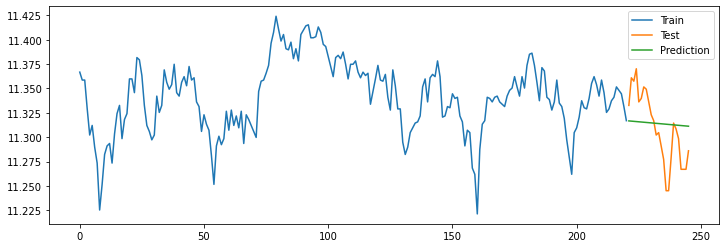

In [79]:
kia_aa_predict = model_kia_aa.predict(n_periods=len(kia_test)) 
kia_aa_predict_df = pd.DataFrame(kia_aa_predict,index = kia_test.index,columns=['Prediction'])

fc_kia_aa = np.array(kia_aa_predict)

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(kia_train, label='Train')        # 훈련 데이터
plt.plot(kia_test, label='Test')          # 테스트 데이터
plt.plot(kia_aa_predict_df, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [80]:
mape_kia_aa = np.mean(np.abs(np.exp(fc_kia_aa) - np.exp(kia_test))/np.abs(np.exp(kia_test)))
print('MAPE: {:.2f}%'.format(mape_kia_aa*100))

MAPE: 2.95%


kia 데이터엔 auto_arima를 사용해 찾은 p, d, q가 예측력을 높였다.

위의 데이터 분포 양상과 다른데도 p, d, q가 위의 두 종목과 같은 값이 나와서

뭔가 잘못된 것 아닌가 싶었는데 확실히 그래프도 하향하는 그래프가 예측되고

MAPE값도 낮아져서 더 나은 값이 맞았다는 것을 알게 되었다.

# 회고

시계열 데이터는 처음 다뤄보았다. 

시계열 데이터를 분석하기 위해 알아야 할 많은 개념들이 낯설었고,

한 개념을 알기 위해 또다른 개념을 정의하고 넘어가야 했으며

각각의 상관관계, 여러 수식을 한 번에 이해하고 넘어가기엔 역부족이었다.

프로젝트는 큰 어려움없이 낮은 MAPE값을 도출할 수 있었지만 

프로젝트를 진행하는 데에 있어 필요한 시계열 데이터에 대한 이해는 수월하지 않았다.

이미 알고 있는 통계 지식과 새로운 지식이 충돌하는 느낌이었고 제대로 정리되지 않은 채 새로운 것들이 들어오니 오히려 더 헷갈리는 것 같다. 

또한 노드에서 진행한 내용 외에도 부가적으로 알아야 하는 

(예를 들어, 잔차의 검정 통계량, 백색 잡음 관련 개념 등)

것들이 제대로 정립되지 않아 다른 프로젝트들 보다 훨씬 어려웠던 프로젝트였던 것 같다. 

시리즈 데이터를 활용한 프로젝트도 이렇게 어려운데

비정형 데이터(음성, 영상, 이미지 등)의 시계열 프로젝트는 얼마나 더 어려울 지 가늠이 되지 않는다.